# **`Health Data EDA`**




This notebook performs:
- Data loading (dirty dataset)
- Quality checks (missing values, duplicates, typos)
- Cleaning and standardization
- Feature engineering (health indicators)
- Exploratory visualizations
- Save a cleaned dataset for Tableau/Tabula

> Input: health_data_dirty.xlsx → Output: health_data_clean.xlsx



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)


In [2]:
# Load the dirty dataset
dirty_path = "/content/health_data_dirty.xlsx"
df = pd.read_excel(dirty_path)
df.head()


,Year,Month,District,Live_Births,ANC_Registrations,Early_ANC_Registrations,ANC_4_Checkups,Institutional_Deliveries,Home_Deliveries,Urban_Institutional_Deliveries,Urban_Home_Deliveries,Rural_Institutional_Deliveries,Rural_Home_Deliveries,Children_Eligible_0_11m,Children_Immunized,Maternal_Deaths,Infant_Deaths
0,2024,Sep,Puri,359.0,NaN,NaN,156.0,257.0,102.0,131,45,126,57,359,376.0,NaN,4.0
1,2023,Mar,Koraput,452.0,458.0,339.0,214.0,366.0,NaN,208,31,158,55,452,NaN,NaN,7.0
2,2023,Nov,Sambalpur,496.0,550.0,NaN,343.0,453.0,43.0,200,11,253,32,496,376.0,2.0,6.0
3,2023,Nov,Puri,770.0,874.0,604.0,533.0,578.0,192.0,390,81,188,111,770,727.0,0.0,11.0
4,2024,Feb,Balasore,708.0,833.0,NaN,357.0,564.0,NaN,394,73,170,71,708,675.0,1.0,9.0


In [3]:
# Shape and basic info
print("Rows, Columns:", df.shape)
print("\nMissing values per column:\n", df.isna().sum())
print("\nDuplicate rows:", df.duplicated().sum())

Rows, Columns: (264, 17)

Missing values per column:
 Year                               0
Month                              0
District                           0
Live_Births                       38
ANC_Registrations                 42
Early_ANC_Registrations           38
ANC_4_Checkups                    41
Institutional_Deliveries          39
Home_Deliveries                   42
Urban_Institutional_Deliveries     0
Urban_Home_Deliveries              0
Rural_Institutional_Deliveries     0
Rural_Home_Deliveries              0
Children_Eligible_0_11m            0
Children_Immunized                37
Maternal_Deaths                   41
Infant_Deaths                     38
dtype: int64

Duplicate rows: 24


### Cleaning Steps



1. Trim spaces and standardize case in District.
2. Map typos/variants to canonical names.
3. Drop duplicates.
4. Impute missing values (median by District, then global median fallback).
5. Recompute engineered features.


In [4]:
# Copy and clean
clean = df.copy()

# Standardize District names
clean['District'] = clean['District'].astype(str).str.strip().str.title()

# Map common variants to canonical names
variant_to_canonical = {
    'Bhubaneshwar': 'Bhubaneswar', 'Bhubaneswar': 'Bhubaneswar',
    'Cuttak': 'Cuttack', 'Cuttack': 'Cuttack',
    'Puri': 'Puri',
    'Sambalpur': 'Sambalpur', 'Sambhalpur': 'Sambalpur',
    'Balasore': 'Balasore', 'Ballasore': 'Balasore', 'Balasor': 'Balasore',
    'Berhampur': 'Berhampur', 'Berhumpur': 'Berhampur',
    'Rourkela': 'Rourkela', 'Rourkella': 'Rourkela',
    'Kendrapara': 'Kendrapara', 'Kendrapra': 'Kendrapara',
    'Koraput': 'Koraput', 'Koraputt': 'Koraput',
    'Mayurbhanj': 'Mayurbhanj', 'Mayurbhanj ': 'Mayurbhanj', 'MayurBhanj': 'Mayurbhanj'
}
clean['District'] = clean['District'].map(lambda x: variant_to_canonical.get(x, x))

# Drop duplicate rows
clean = clean.drop_duplicates()

# Impute numeric columns
num_cols = [
    "Live_Births","ANC_Registrations","Early_ANC_Registrations","ANC_4_Checkups",
    "Institutional_Deliveries","Home_Deliveries","Children_Immunized",
    "Maternal_Deaths","Infant_Deaths"
]
for col in num_cols:
    if col in clean.columns:
        clean[col] = clean.groupby('District')[col].transform(lambda s: s.fillna(s.median()))
        clean[col] = clean[col].fillna(clean[col].median())

clean.head()

,Year,Month,District,Live_Births,ANC_Registrations,Early_ANC_Registrations,ANC_4_Checkups,Institutional_Deliveries,Home_Deliveries,Urban_Institutional_Deliveries,Urban_Home_Deliveries,Rural_Institutional_Deliveries,Rural_Home_Deliveries,Children_Eligible_0_11m,Children_Immunized,Maternal_Deaths,Infant_Deaths
0,2024,Sep,Puri,359.0,712.0,507.0,156.0,257.0,102.0,131,45,126,57,359,376.0,0.5,4.0
1,2023,Mar,Koraput,452.0,458.0,339.0,214.0,366.0,106.0,208,31,158,55,452,689.0,1.5,7.0
2,2023,Nov,Sambalpur,496.0,550.0,328.0,343.0,453.0,43.0,200,11,253,32,496,376.0,2.0,6.0
3,2023,Nov,Puri,770.0,874.0,604.0,533.0,578.0,192.0,390,81,188,111,770,727.0,0.0,11.0
4,2024,Feb,Balasore,708.0,833.0,379.0,357.0,564.0,128.0,394,73,170,71,708,675.0,1.0,9.0


In [6]:
print("\nMissing values per column:\n", clean.isna().sum())


Missing values per column:
 Year                              0
Month                             0
District                          0
Live_Births                       0
ANC_Registrations                 0
Early_ANC_Registrations           0
ANC_4_Checkups                    0
Institutional_Deliveries          0
Home_Deliveries                   0
Urban_Institutional_Deliveries    0
Urban_Home_Deliveries             0
Rural_Institutional_Deliveries    0
Rural_Home_Deliveries             0
Children_Eligible_0_11m           0
Children_Immunized                0
Maternal_Deaths                   0
Infant_Deaths                     0
dtype: int64


### Feature Engineering





- **ANC_Care_Index** = Early_ANC_Registrations / ANC_Registrations
- **ANC_Completion_Rate** = ANC_4_Checkups / ANC_Registrations
- **Institutional_Delivery_Rate** = Institutional / (Institutional + Home)
- **Immunization_Coverage** = Children_Immunized / Children_Eligible_0_11m
- **MMR** = Maternal_Deaths per 100,000 live births
- **IMR** = Infant_Deaths per 1,000 live births
- **Urban vs Rural Delivery Rates** and **Rural–Urban Gap**
- **Composite Health Index** (weighted blend, mortality inverted)


In [7]:
eps = 1e-9

clean['ANC_Care_Index'] = (clean['Early_ANC_Registrations'] / (clean['ANC_Registrations'] + eps)) * 100
clean['ANC_Completion_Rate'] = (clean['ANC_4_Checkups'] / (clean['ANC_Registrations'] + eps)) * 100
clean['Institutional_Delivery_Rate'] = (clean['Institutional_Deliveries'] / (clean['Institutional_Deliveries'] + clean['Home_Deliveries'] + eps)) * 100
clean['Immunization_Coverage'] = (clean['Children_Immunized'] / (clean['Children_Eligible_0_11m'] + eps)) * 100

clean['MMR'] = (clean['Maternal_Deaths'] / (clean['Live_Births'] + eps)) * 100000
clean['IMR'] = (clean['Infant_Deaths'] / (clean['Live_Births'] + eps)) * 1000

urban_den = clean['Urban_Institutional_Deliveries'] + clean['Urban_Home_Deliveries'] + eps
rural_den = clean['Rural_Institutional_Deliveries'] + clean['Rural_Home_Deliveries'] + eps
clean['Urban_Delivery_Rate'] = (clean['Urban_Institutional_Deliveries'] / urban_den) * 100
clean['Rural_Delivery_Rate'] = (clean['Rural_Institutional_Deliveries'] / rural_den) * 100
clean['Rural_Urban_Gap'] = clean['Urban_Delivery_Rate'] - clean['Rural_Delivery_Rate']

for metric in ['MMR','IMR']:
    m_min, m_max = clean[metric].min(), clean[metric].max()
    if m_max - m_min > 0:
        clean[f'{metric}_Score'] = 100 * (1 - (clean[metric] - m_min) / (m_max - m_min))
    else:
        clean[f'{metric}_Score'] = 100.0

clean['Composite_Health_Index'] = (
    0.25*clean['ANC_Care_Index'] + 0.20*clean['ANC_Completion_Rate'] +
    0.25*clean['Institutional_Delivery_Rate'] + 0.15*clean['Immunization_Coverage'] +
    0.075*clean['MMR_Score'] + 0.075*clean['IMR_Score']
)

clean.head()

,Year,Month,District,Live_Births,ANC_Registrations,Early_ANC_Registrations,ANC_4_Checkups,Institutional_Deliveries,Home_Deliveries,Urban_Institutional_Deliveries,Urban_Home_Deliveries,Rural_Institutional_Deliveries,Rural_Home_Deliveries,Children_Eligible_0_11m,Children_Immunized,Maternal_Deaths,Infant_Deaths,ANC_Care_Index,ANC_Completion_Rate,Institutional_Delivery_Rate,Immunization_Coverage,MMR,IMR,Urban_Delivery_Rate,Rural_Delivery_Rate,Rural_Urban_Gap,MMR_Score,IMR_Score,Composite_Health_Index
0,2024,Sep,Puri,359.0,712.0,507.0,156.0,257.0,102.0,131,45,126,57,359,376.0,0.5,4.0,71.207865,21.910112,71.587744,104.735376,139.275766,11.142061,74.431818,68.852459,5.579359,85.190344,74.558090,67.772364
1,2023,Mar,Koraput,452.0,458.0,339.0,214.0,366.0,106.0,208,31,158,55,452,689.0,1.5,7.0,74.017467,46.724891,77.542373,152.433628,331.858407,15.486726,87.029289,74.178404,12.850885,64.712389,63.092308,79.685335
2,2023,Nov,Sambalpur,496.0,550.0,328.0,343.0,453.0,43.0,200,11,253,32,496,376.0,2.0,6.0,59.636364,62.363636,91.330645,75.806452,403.225806,12.096774,94.786730,88.771930,6.014800,57.123656,72.038556,71.272613
3,2023,Nov,Puri,770.0,874.0,604.0,533.0,578.0,192.0,390,81,188,111,770,727.0,0.0,11.0,69.107551,60.983982,75.064935,94.415584,0.000000,14.285714,82.802548,62.876254,19.926294,100.000000,66.261836,74.871893
4,2024,Feb,Balasore,708.0,833.0,379.0,357.0,564.0,128.0,394,73,170,71,708,675.0,1.0,9.0,45.498199,42.857143,81.502890,95.338983,141.242938,12.711864,84.368308,70.539419,13.828889,84.981168,70.415303,66.277284


In [9]:
#Save cleaned dataset from the notebook too
clean.to_excel("/content/health_data_clean.xlsx", index=False)
print("Saved:", "/content/health_data_clean.xlsx")

Saved: /content/health_data_clean.xlsx


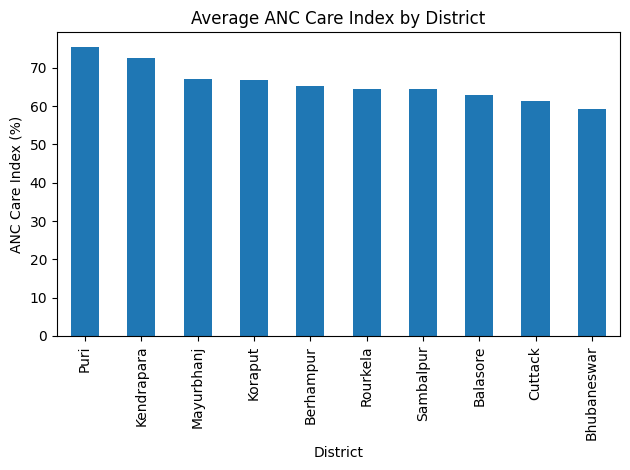

In [10]:
# 1) Average ANC Care Index by District (bar)
import matplotlib.pyplot as plt

plt.figure()
avg_anc_idx = clean.groupby('District')['ANC_Care_Index'].mean().sort_values(ascending=False)
avg_anc_idx.plot(kind='bar')
plt.title('Average ANC Care Index by District')
plt.xlabel('District')
plt.ylabel('ANC Care Index (%)')
plt.tight_layout()
plt.show()

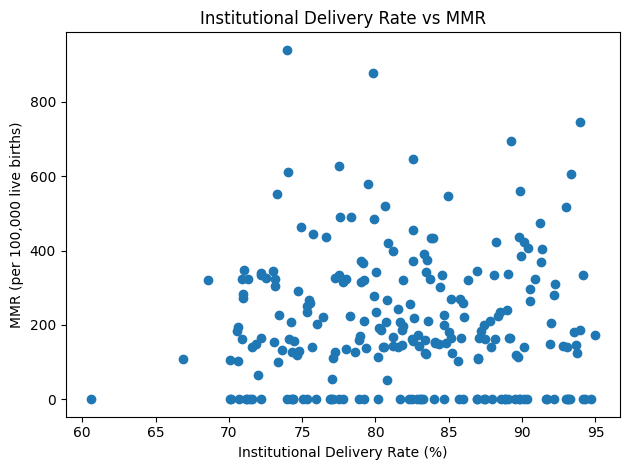

In [11]:
# 2) Institutional Delivery Rate vs MMR (scatter)
plt.figure()
plt.scatter(clean['Institutional_Delivery_Rate'], clean['MMR'])
plt.title('Institutional Delivery Rate vs MMR')
plt.xlabel('Institutional Delivery Rate (%)')
plt.ylabel('MMR (per 100,000 live births)')
plt.tight_layout()
plt.show()

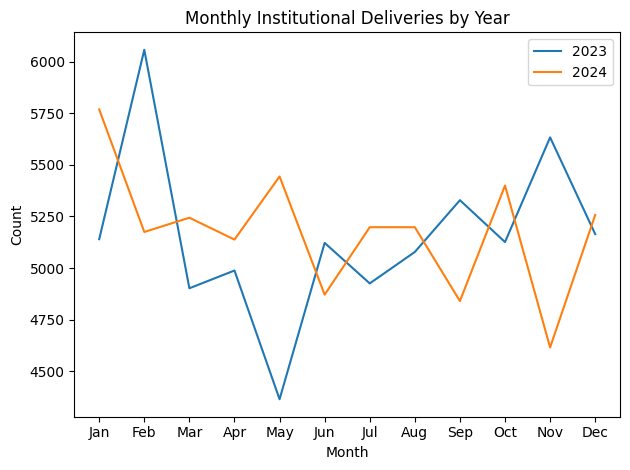

In [12]:
# 3) Monthly trend of Institutional Deliveries by Year
plt.figure()
monthly = clean.groupby(['Year','Month'])['Institutional_Deliveries'].sum().reset_index()
order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthly['Month'] = pd.Categorical(monthly['Month'], categories=order, ordered=True)
for y in sorted(monthly['Year'].unique()):
    tmp = monthly[monthly['Year']==y].sort_values('Month')
    plt.plot(tmp['Month'].astype(str), tmp['Institutional_Deliveries'], label=str(y))
plt.title('Monthly Institutional Deliveries by Year')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

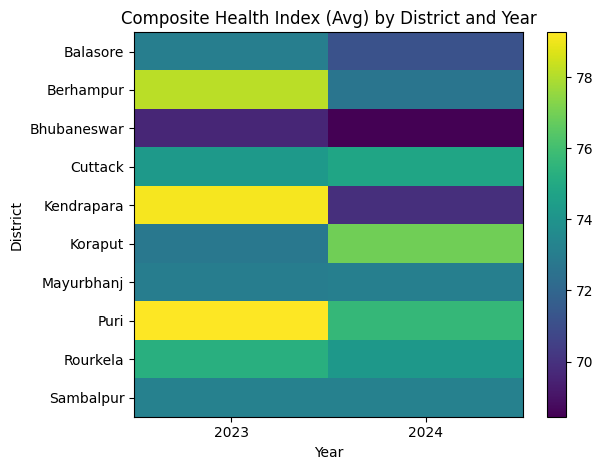

In [13]:
# 4) Heatmap: Composite Health Index by District & Year
pivot = clean.pivot_table(index='District', columns='Year', values='Composite_Health_Index', aggfunc='mean')
plt.figure()
plt.imshow(pivot.values, aspect='auto')
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title('Composite Health Index (Avg) by District and Year')
plt.xlabel('Year')
plt.ylabel('District')
plt.colorbar()
plt.tight_layout()
plt.show()